In [1]:
# Matching and Merging Notebook

## This notebook will be used to match team names from the conference history csv files to the csv with information on FBS teams
# Once the team names are standerized then they need to be matched to the 
# game results csv

# Will then filter the game results csv to only include games with an FBS team
# Also want to classify games as conference games or no conference, postseason or not

# dependencies
import pandas as pd
import numpy as np

# read in the csv files
# conference info
conf_info = pd.read_csv('../data/cfb_conference_members.csv')

# game results - all
game_results = pd.read_csv('../data/cfb_scores_all_years.csv')

# FBS Team table
fbs_teams = pd.read_csv('../data/cfb_d1_teams_with_coordinates.csv')

# Conference member matrix by year
# conf_members = pd.read_csv('../data/yearly_conference_members.csv')
# Rename index column to "Year"
# conf_members = conf_members.rename(columns={'Unnamed: 0': 'Year'})



C:\Users\Justin\AppData\Local\Temp\ipykernel_9832\2790867705.py:19: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  game_results = pd.read_csv('../data/cfb_scores_all_years.csv')


In [2]:
## Generate reports about the data

print('----------------------------------------------')

print(f'Conference Info Table: {conf_info.shape}')
print('')
conf_info.head()
conf_info.describe()
conf_info.info()
print('----------------------------------------------')
print('----------------------------------------------')
print('')

print(f'Game Results - All Results: {game_results.shape}')
print('')
game_results.head()
game_results.describe()
game_results.info()
print('----------------------------------------------')
print('')

print(f'FBS Team Table: {fbs_teams.shape}')
print('')
fbs_teams.head()
fbs_teams.describe()
fbs_teams.info()
print('----------------------------------------------')
print('')

# print(f'Conference Member Matrix by Year: {conf_members.shape}')
# print('')
# conf_members.head()
# conf_members.describe()
# conf_members.info()
# print('----------------------------------------------')
# print('')



----------------------------------------------
Conference Info Table: (358, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Institution  358 non-null    object 
 1   Nickname     345 non-null    object 
 2   Location     317 non-null    object 
 3   Founded      314 non-null    float64
 4   Joined       354 non-null    float64
 5   Left         221 non-null    float64
 6   Enrollment   284 non-null    object 
 7   Conference   358 non-null    object 
dtypes: float64(3), object(5)
memory usage: 22.5+ KB
----------------------------------------------
----------------------------------------------

Game Results - All Results: (81604, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81604 entries, 0 to 81603
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk         

In [3]:
# Value counts for the conference info table
conf_info['Conference'].value_counts()

Conference USA                  46
Sun Belt Conference             42
Western Athletic Conference     28
Missouri Valley Conference      27
Big 12                          22
American Athletic Conference    21
ACC                             20
Big Ten Conference              19
Mid-American Conference         19
SEC                             16
Mountain West Conference        14
Southwest Conference            13
Big 8 Conference                12
Pac-12 Conference               12
Big East Conference             11
Pacific Coast Conference        10
Border Conference                9
Skyline Conference               9
Ivy League                       8
Name: Conference, dtype: int64

In [4]:
# conf_members.head()



# Extract the team's ranking from the team name if it exists and store in new column - 
# Rankings are in parenthesis at the begining of the team name

# Create a function to extract the ranking from the team name - both Winner and Loser columns
import re


def extract_ranking(team_name):
    match = re.match(r'^\((\d{1,2})\)', team_name)
    return int(match.group(1)) if match else np.nan

# Extract rankings
game_results['Winner_Ranking'] = game_results['Winner'].apply(extract_ranking)
game_results['Loser_Ranking'] = game_results['Loser'].apply(extract_ranking)

# Clean up team names
game_results['Winner'] = game_results['Winner'].str.replace(r'^\(\d{1,2}\)\s', '').str.strip()
game_results['Loser'] = game_results['Loser'].str.replace(r'^\(\d{1,2}\)\s', '').str.strip()

# game_results.sample(20)
# Save the game results to a csv

        

C:\Users\Justin\AppData\Local\Temp\ipykernel_9832\4294059336.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  game_results['Winner'] = game_results['Winner'].str.replace(r'^\(\d{1,2}\)\s', '').str.strip()
C:\Users\Justin\AppData\Local\Temp\ipykernel_9832\4294059336.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  game_results['Loser'] = game_results['Loser'].str.replace(r'^\(\d{1,2}\)\s', '').str.strip()


In [5]:
## Map replacements for the team names in the FBS team table - based on names used in game results table


# Create a dictionary of the replacements
replacements = {'Uconn': 'Connecticut',
                'Middle Tennessee': 'Middle Tennessee State',
                'Sam Houston': 'Sam Houston State',
                'Oregon[n 14]': 'Oregon',
                'Southern Miss': 'Southern Mississippi',
                'UTEP': 'Texas-El Paso',
                'UTSA': 'Texas-San Antonio',
                'UMass': 'Massachusetts',
                'UConn': 'Connecticut',
                'BYU': 'Brigham Young',
                'TCU': 'Texas Christian',
                'UAB': 'Alabama-Birmingham',
                'UNLV': 'Nevada-Las Vegas',
                'Ole Miss': 'Mississippi',
                'LSU': 'Louisiana State',
                'UCF': 'Central Florida',
                'FIU': 'Florida International',
                'SMU': 'Southern Methodist',
                'NC State': 'North Carolina State',
                'USC': 'Southern California'}

# replace the team names in the FBS & Conf tables
fbs_teams['Team'] = fbs_teams['Team'].replace(replacements)
conf_info['Institution'] = conf_info['Institution'].replace(replacements)


In [6]:
## fuzzy match the team names to the FBS team table

import fuzzywuzzy
from fuzzywuzzy import process
from fuzzywuzzy import fuzz


# create a list of the team names from the conference table
conf_team_list = conf_info['Institution'].tolist()

# create a list of the team names from the FBS team table
fbs_team_list = fbs_teams['Team'].tolist()

# run the match for each unique name in the conf_team_list and create a dataframe of the results including the score

# create an empty list to store the results
match_results = []

# loop through the conf_team_list and match each team to the fbs_team_list
for team in fbs_team_list:
    match = process.extractOne(team, fbs_team_list)
    match_results.append(match)

# create a dataframe of the results
match_results_df = pd.DataFrame(match_results, columns=['Match', 'Score'])

# add the conf_team_list to the dataframe
# match_results_df['Conf_Team'] = conf_team_list

# add the fbs_team_list to the dataframe
match_results_df['FBS_Team'] = fbs_team_list

# reorder the columns
# match_results_df = match_results_df[['Conf_Team', 'Match', 'Score']]

# sort the dataframe by the score
match_results_df = match_results_df.sort_values(by=['Score'], ascending=False)



In [7]:
# match_results_df.head(20)

# match_results_df.describe() 

## It seems all the names match. This makes sense because the source for both tables is Wikipedia

In [8]:
game_results.head()

,Rk,Wk,Date,Day,Winner,Pts,Unnamed: 6,Loser,Pts.1,Notes,Year,Time,Unnamed: 7,Winner_Ranking,Loser_Ranking
0,1,1,"Nov 6, 1869",Sat,Rutgers,6.0,NaN,Princeton,4.0,NaN,1869,NaN,NaN,NaN,NaN
1,2,2,"Nov 13, 1869",Sat,Princeton,8.0,NaN,Rutgers,0.0,NaN,1869,NaN,NaN,NaN,NaN
2,1,1,"Nov 5, 1870",Sat,Rutgers,6.0,NaN,Columbia,3.0,NaN,1870,NaN,NaN,NaN,NaN
3,2,2,"Nov 12, 1870",Sat,Princeton,6.0,NaN,Rutgers,2.0,NaN,1870,NaN,NaN,NaN,NaN
4,1,1,"Nov 2, 1872",Sat,Rutgers,0.0,@,Columbia,0.0,NaN,1872,NaN,NaN,NaN,NaN


In [9]:
## Match the team names to the game results table

# create a list of the team names from the game results table
# Extract unique team names from both 'Winner' and 'Loser' columns
game_team_list = pd.concat([game_results['Winner'], game_results['Loser']]).unique().tolist()

len(game_team_list)





1350

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Match          133 non-null    object
 1   Score          133 non-null    int64 
 2   FBS_List_Name  133 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.2+ KB


<AxesSubplot:>

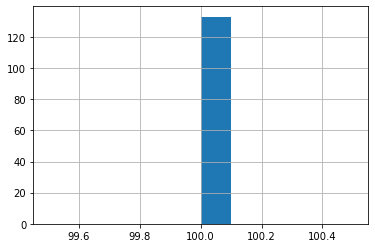

In [10]:
## Version 2

# Look for match teams from the FBS team table to the game results table
# create an empty list to store the results
match_results = []

# loop through the fbs_team_list and match each team to the fbs_team_list
for team in fbs_team_list:
    match = process.extractOne(team, game_team_list)
    match_results.append(match)

# create a dataframe of the results
match_results_df_2 = pd.DataFrame(match_results, columns=['Match', 'Score'])

# add the conf_team_list to the dataframe
match_results_df_2['FBS_List_Name'] = fbs_team_list

match_results_df_2.info()

# Sort the dataframe by the score
match_results_df_2 = match_results_df_2.sort_values(by=['Score'], ascending=False)

# Histogram of the scores
match_results_df_2['Score'].hist()



In [11]:

## Now Matching at 100% - Need to did into game result data a bit more in the future to make sure
# Institution / Team names that may have changed (example MAC to Michigan State) are accounted for


# match_results_df_2.tail(20)

# match_results_df_2.describe()


In [12]:
#### GAMES WITH AT LEAST A SINGLE FBS TEAM
# Identify the rows from the game results table involve FBS teams

# Filter game_results table to only include games with an FBS team
# Create a list of the FBS team names
fbs_team_list = match_results_df_2['FBS_List_Name'].tolist()

# Filter the game_results table to only include games with an FBS team in either the Winner or Loser column
fbs_game_results = game_results[game_results['Winner'].isin(fbs_team_list) | game_results['Loser'].isin(fbs_team_list)]

# Save a csv to the TEMP directory
fbs_game_results.to_csv('../TEMP/1FBS_Team_results_raw.csv', index=False)

fbs_game_results.head()

fbs_game_results.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 68236 entries, 0 to 81603
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rk              68236 non-null  int64  
 1   Wk              68236 non-null  int64  
 2   Date            68236 non-null  object 
 3   Day             68236 non-null  object 
 4   Winner          68236 non-null  object 
 5   Pts             68234 non-null  float64
 6   Unnamed: 6      24979 non-null  object 
 7   Loser           68236 non-null  object 
 8   Pts.1           68234 non-null  float64
 9   Notes           5148 non-null   object 
 10  Year            68236 non-null  int64  
 11  Time            7341 non-null   object 
 12  Unnamed: 7      3539 non-null   object 
 13  Winner_Ranking  14662 non-null  float64
 14  Loser_Ranking   5836 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 8.3+ MB


In [13]:
# Valuecount for winner and loser
fbs_game_results['Winner'].value_counts()
# fbs_game_results['Loser'].value_counts()

# Number of unique teams in both winner and loser columns
# fbs_game_results['Winner'].nunique()
# fbs_game_results['Loser'].nunique()



Alabama              981
Michigan             978
Penn State           926
Notre Dame           915
Oklahoma             911
                    ... 
Fort Pierce            1
Fleet City             1
Jackson Field          1
Melville PT Boats      1
Camp Taylor            1
Name: Winner, Length: 544, dtype: int64

In [14]:
# #### GAMES WITH TWO FBS TEAMS
# # Identify the rows from the game results table involve 2 FBS teams

# # Filter game_results table to only include games with 2 FBS teams
# # Create a list of the FBS team names
# fbs_team_list = match_results_df_2['FBS_List_Name'].tolist()

# # Filter the game_results table to only include games with 2 FBS teams in either the Winner or Loser column
# fbs_game_results_2 = game_results[game_results['Winner'].isin(fbs_team_list) & game_results['Loser'].isin(fbs_team_list)]


# # Save a csv to the TEMP directory
# fbs_game_results_2.to_csv('../TEMP/2FBS_Team_results_raw.csv', index=False)

# fbs_game_results_2.head()

# fbs_game_results_2.info()

# # Valuecount for winner and loser
# # fbs_game_results_2['Winner'].value_counts()
# fbs_game_results_2['Loser'].value_counts()

# # Number of unique teams in both winner and loser columns
# # fbs_game_results_2['Winner'].nunique()
# # fbs_game_results_2['Loser'].nunique()





In [15]:
## Classify games as being in conference or out of conference
# In conference games wll be denoted by a 1, out of conference games will be denoted by a 0
# A game is in conference if the two teams are in the same conference in the same year according to the yearly conference membership data

# Only look at games with 2 FBS teams
# fbs_game_results_2.head()





In [16]:
# import ast
from ast import literal_eval
import ast

df = fbs_game_results.copy()

### Classify as conference or non conf games

conference_df = pd.read_csv('../data/yearly_conference_members.csv')
# Convert the conference affiliation dataframe into a dictionary for faster lookups
conference_dict = {}
for _, row in conference_df.iterrows():
    year = row['Unnamed: 0']
    conference_dict[year] = {}
    for col in conference_df.columns[1:]:
        teams = ast.literal_eval(row[col])
        for team in teams:
            conference_dict[year][team] = col

# Using the dictionary to classify games in the game results dataframe
def classify_game_optimized(row):
    year = row['Year']
    winner = row['Winner']
    loser = row['Loser']
    
    winner_conference = conference_dict.get(year, {}).get(winner, None)
    loser_conference = conference_dict.get(year, {}).get(loser, None)
    
    if winner_conference == loser_conference and winner_conference is not None:
        return "Conference Game"
    else:
        return "Non-Conference Game"

# function to add the conference name to the game results table
def add_conference_name(row):
    year = row['Year']
    winner = row['Winner']
    loser = row['Loser']
    
    winner_conference = conference_dict.get(year, {}).get(winner, None)
    loser_conference = conference_dict.get(year, {}).get(loser, None)
    
    if winner_conference == loser_conference and winner_conference is not None:
        return winner_conference
    else:
        return "Non-Conference Game"

# Apply the function to the dataframe
df['Game Type'] = df.apply(classify_game_optimized, axis=1)

df['Conference'] = df.apply(add_conference_name, axis=1)

# Preview the updated dataframe with the new "Game Type" column
df.head()


,Rk,Wk,Date,Day,Winner,Pts,Unnamed: 6,Loser,Pts.1,Notes,Year,Time,Unnamed: 7,Winner_Ranking,Loser_Ranking,Game Type,Conference
0,1,1,"Nov 6, 1869",Sat,Rutgers,6.0,NaN,Princeton,4.0,NaN,1869,NaN,NaN,NaN,NaN,Non-Conference Game,Non-Conference Game
1,2,2,"Nov 13, 1869",Sat,Princeton,8.0,NaN,Rutgers,0.0,NaN,1869,NaN,NaN,NaN,NaN,Non-Conference Game,Non-Conference Game
2,1,1,"Nov 5, 1870",Sat,Rutgers,6.0,NaN,Columbia,3.0,NaN,1870,NaN,NaN,NaN,NaN,Non-Conference Game,Non-Conference Game
3,2,2,"Nov 12, 1870",Sat,Princeton,6.0,NaN,Rutgers,2.0,NaN,1870,NaN,NaN,NaN,NaN,Non-Conference Game,Non-Conference Game
4,1,1,"Nov 2, 1872",Sat,Rutgers,0.0,@,Columbia,0.0,NaN,1872,NaN,NaN,NaN,NaN,Non-Conference Game,Non-Conference Game


In [17]:
# get a df of just conference games
conf_game_results = df[df['Game Type'] == 'Conference Game']

# df of just non conference games
non_conf_game_results = df[df['Game Type'] == 'Non-Conference Game']

len(conf_game_results)

17041

In [18]:
# Total conference vs non conference games per year
# conf_game_results['Year'].hist()

# non conf game histogram
# non_conf_game_results['Year'].hist()


# Total conference vs non conference games
# conf_game_results['Game Type'].value_counts()

# df







In [19]:
df.sample(20)

conf_game_results.sample(20)

,Rk,Wk,Date,Day,Winner,Pts,Unnamed: 6,Loser,Pts.1,Notes,Year,Time,Unnamed: 7,Winner_Ranking,Loser_Ranking,Game Type,Conference
55635,355,9,"Oct 22, 1988",Sat,Arkansas,26.0,@,Houston,21.0,NaN,1988,NaN,NaN,13.0,NaN,Conference Game,Southwest Conference
61226,186,5,"Sep 20, 1997",Sat,Toledo,23.0,@,Western Michigan,13.0,NaN,1997,NaN,NaN,NaN,NaN,Conference Game,Mid-American Conference
56168,252,6,"Oct 7, 1989",Sat,Iowa State,24.0,@,Kansas,20.0,NaN,1989,NaN,NaN,NaN,NaN,Conference Game,Big 8 Conference
78307,829,15,"Nov 30, 2018",Fri,Northern Illinois,30.0,NaN,Buffalo,29.0,"MAC Championship (Detroit, MI)",2018,7:00 PM,N,NaN,NaN,Conference Game,Mid-American Conference
52196,231,6,"Oct 1, 1983",Sat,Central Michigan,13.0,NaN,Kent State,7.0,NaN,1983,NaN,NaN,NaN,NaN,Conference Game,Mid-American Conference
65835,586,12,"Nov 8, 2003",Sat,Ohio State,33.0,NaN,Michigan State,23.0,NaN,2003,NaN,NaN,7.0,14.0,Conference Game,Big Ten Conference
73859,716,13,"Nov 23, 2013",Sat,Mississippi State,24.0,NaN,Arkansas,17.0,NaN,2013,12:21 PM,@,NaN,NaN,Conference Game,SEC
63366,300,7,"Oct 7, 2000",Sat,Florida,41.0,NaN,Louisiana State,9.0,NaN,2000,NaN,NaN,12.0,NaN,Conference Game,SEC
42271,455,10,"Oct 31, 1970",Sat,Michigan State,32.0,@,Indiana,7.0,NaN,1970,NaN,NaN,NaN,NaN,Conference Game,Big Ten Conference
77903,425,8,"Oct 13, 2018",Sat,Colorado State,20.0,NaN,New Mexico,18.0,Sonny Lubick Field at Canvas Stadium - Fort Co...,2018,4:00 PM,NaN,NaN,NaN,Conference Game,Mountain West Conference


In [20]:
## Value count of Conference names
df['Conference'].value_counts()

Non-Conference Game             51195
Big Ten Conference               3933
SEC                              3079
Mid-American Conference          1639
Big 8 Conference                 1568
Pac-12 Conference                1431
Southwest Conference             1039
ACC                               896
Conference USA                    657
Pacific Coast Conference          647
Skyline Conference                466
Sun Belt Conference               421
Western Athletic Conference       376
Missouri Valley Conference        352
Border Conference                 210
Mountain West Conference          209
Big East Conference               111
American Athletic Conference        7
Name: Conference, dtype: int64